In [955]:
import matplotlib.pyplot as plt
from torch.autograd import Variable
import torch
from time import time
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torchvision.datasets import ImageFolder
from torch.utils.data import Subset
from sklearn.model_selection import train_test_split
from torchvision.transforms import Compose, ToTensor, Resize
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

In [956]:
from google.colab import drive # import google drive as a folder to colab environment
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [957]:
#!unzip '/content/drive/MyDrive/MNIST_Data.zip'

# Functions:

In [958]:
def train_val_dataset(dataset, val_split=0.4):
    train_data, val_data = train_test_split(list(range(len(dataset))), test_size=val_split)
    train_dataset = Subset(dataset, train_data)
    val_dataset = Subset(dataset, val_data)
    return train_dataset , val_dataset

## Tranforms and Dataloader
>*Code in the cell below loads dataset so that we can train model on it and test our trained model. First two statements define tranforms to transform our dataset. Images are of size(28 * 28) and normalized and converted to pytorch tensors.Image folder is loaded using ImageFolder Object and then it is passed as argument to Dataloader Object to load data at run time.*






In [959]:
def dataset_load(transforms,batch):
  # Loading Datasets using ImageFolder
  train_dataset = ImageFolder('/content/train' , transform=transforms) 
  print(len(train_dataset), 'Original Train Data')
  test_dataset = ImageFolder('/content/test' , transform=transforms)
  print(len(test_dataset) , "Length of Test Data")

  # Train_Validation_Split
  train_data , val_data = train_val_dataset(train_dataset)

  print(len(train_data), "Length of Training Data")
  print(len(val_data), "Length of Validation Data")

  # Train and Test dataloaders
  train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch, shuffle=True)
  val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch, shuffle=True)
  test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch, shuffle=True)
  print(len(train_loader), len(val_loader), len(test_loader))
  
  return train_loader,val_loader,test_loader

##Neural Network
*This cell defines our dynamic neural network.Forward function is compulsery to implement if we are extending nn.Module class. It specify's what happens to the input image. Relu is used as non-linearity in this case.*


In [960]:
class Network(nn.Module):
    def __init__(self,no_of_layers, input_dim, neurons_per_layer, dropout):
        super(Network, self).__init__()
        self.hidden = []
        self.layers = no_of_layers

        for i in range(self.layers):
               if i == 0:
                 self.hidden.append(nn.Linear(input_dim, neurons_per_layer[i]))                

               else:
                 self.hidden.append(nn.Linear(neurons_per_layer[i-1], neurons_per_layer[i]))
                 input_dim = neurons_per_layer[i]

                 
        self.hidden = nn.ModuleList(self.hidden)
        self.final = nn.Linear(input_dim , neurons_per_layer[-1])
        self.dropout = nn.Dropout(dropout)
  
    def forward(self, x): 
      for i in range(self.layers):
           x = F.relu(self.hidden[i](x))
      
      x = self.dropout(x)
      x = F.log_softmax(self.final(x),dim = 1)
      return x


In this function we create object of Network class and specify learning rate and number of epochs. 

In [961]:
def init_network(no_of_layers, input_dim, neurons_per_layer,dropout,device):
  model = Network(no_of_layers, input_dim, neurons_per_layer,dropout)
  model.to(device)
  return model



## Train the Network
In this cell we choose optimizer and loss function. We are using stochastic gradient descent as our optimizer and cross entropy loss as our loss function.

Training neural network is done in multiple steps. After extracting data and target from the train loader, we assign them to the device. 

In [962]:
def train(net, train_loader, val_loader,learning_rate, training_epochs, loss_func, optimizer, device):
  time0 = time()
  #optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
  train_loss, val_loss=[],[]
  train_acc, val_acc=[],[]
  for epoch in range(training_epochs):
    t_loss=0
    t_correct = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target)
        data, target = data.to(device), target.to(device)        
        data = data.view(-1, 784)
        optimizer.zero_grad()
        net_out = model(data)
        loss = loss_func(net_out, target)
        loss.backward()
        optimizer.step()
        t_loss += loss.item()
        pred = net_out.data.max(1)[1]  # get the index of the max log-probability
        t_correct += pred.eq(target.data).sum()
        
            
    train_loss.append(t_loss/len(train_loader.dataset))
    train_acc.append(t_correct/len(train_loader.dataset))
   
    print("------------------------------------------------------------------------------------------------")
    print('Epoch: ', epoch)
    print('Training Loss:', t_loss / len(train_loader.dataset)) 
    print("Training Accuracy:", 100. * t_correct.item() / len(train_loader.dataset) )
    print("------------------------------------------------------------------------------------------------") 
     
    v_loss=0
    v_correct=0

    for batch_idx, (data, target) in enumerate(val_loader):
        data, target = Variable(data), Variable(target)
        data, target = data.to(device), target.to(device)        
        data = data.view(-1, 784)
        net_out = model(data)
        loss = loss_func(net_out, target)
        v_loss += loss.item()
        pred = net_out.data.max(1)[1]  # get the index of the max log-probability
        v_correct += pred.eq(target.data).sum() 

    val_loss.append(v_loss/len(val_loader.dataset))
    val_acc.append(v_correct/len(val_loader.dataset))
    print("------------------------------------------------------------------------------------------------")
    print('Epoch: ', epoch)
    print('Validation Loss:', t_loss / len(val_loader.dataset)) 
    print("Validation Accuracy:", 100. * v_correct.item() / len(val_loader.dataset) )
    print("------------------------------------------------------------------------------------------------") 
  
  # average test loss
  t_loss = t_loss/len(train_loader.dataset)
  print('Train Loss: {:.6f}\n'.format(t_loss))
  
  print('\nTrain set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(t_loss, t_correct, len(train_loader.dataset),100. * t_correct / len(train_loader.dataset)))
  print("\nTraining Time (in minutes) =",(time()-time0)/60)
  return net, train_loss, train_acc, val_loss, val_acc

In [963]:
def save_network(path , model):
  torch.save(model.state_dict(), path)

In [964]:
def load_network(path, model):
  model.load_state_dict(torch.load(path))


# Test Network

In [965]:
def test(model, device, test_loader):
    model.eval()
    actuals = []
    predictions = []
    class_correct=[0]*10
    class_total=[0]*10
    test_accuracy=[]
    test_loss=[]
    t_loss =0
    correct=0
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = Variable(data), Variable(target)
            data, target = data.to(device), target.to(device)
            data = data.view(-1, 784)
            net_out = model(data)
            loss = loss_func(net_out, target)
            
            pred=net_out.data.max(1)[1]
            correct_tensor = pred.eq(target.data.view_as(pred))
            correct = np.squeeze(correct_tensor.numpy()) if device == "cpu" else np.squeeze(correct_tensor.cpu().numpy())
                 
            for i in range(target.size(0)):
                
                label = target.data[i]
                class_correct[label] += correct[i].item()
                class_total[label] += 1
                #Statistics
            prediction = net_out.argmax(dim=1)
            actuals.extend(target.view_as(prediction))
            predictions.extend(prediction)
        
        for i in range(10):
              t_loss += loss.item()
              test_loss.append(t_loss / len(test_loader.dataset))
              test_accuracy.append(100 * class_correct[i] / class_total[i])

        
        
        print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (100. * np.sum(class_correct) / np.sum(class_total), np.sum(class_correct), np.sum(class_total)))
        
    
    return [i.item() for i in actuals], [i.item() for i in predictions], test_accuracy, test_loss
    
    

In [966]:
def conf(actuals, predictions):
  print('---------------------------F1 & Accuracy Score--------------------------\n')
  
  print('Testing f1 score: %f' % f1_score(actuals, predictions, average='weighted'))
  print('Testing accuracy score: %f' % accuracy_score(actuals, predictions))

  print('------------------------Confusion matrix----------------------------------')
  import seaborn as sns
  plt.figure(figsize=(10,9))
  ax = sns.heatmap(confusion_matrix(actuals, predictions), annot=True, vmax=20)
  ax.set_xlabel('Predicted')
  ax.set_ylabel('True')
  plt.show()
  



# Visualizations

In [967]:
def train_vitualization(train_loss,train_accuracy,val_loss,val_accuracy):

  plt.figure(figsize=(3,3))
  plt.title("Plot the resulting loss over time") 
  plt.plot(train_loss, label='Training Loss')
  plt.plot(val_loss, label='Validation Loss')
  plt.legend()
  plt.show()

  plt.figure(figsize=(3,3))
  plt.title("Plot the Resulting Acuracy over time")
  plt.plot(train_accuracy, label='Training Accuracy')
  plt.plot(val_accuracy, label='Validation Accuracy')
  plt.legend()
  plt.show()

def test_vitualization(actuals,predictions,test_accuracy,test_loss):
  
  plt.figure(figsize=(3,3))
  plt.title("Plot the Testing Loss over time\n")
  plt.plot(test_loss, label='Test Loss')
  plt.show()

  plt.figure(figsize=(3,3))
  plt.title("Plot the Testing Acuracy over time")
  plt.plot(test_accuracy, label='Test Accuracy')
  plt.show()

  conf(actuals,predictions)


# Classification

In [968]:
def classify(img, ps):
    ''' 
    Function for viewing an image and it's predicted classes.
    '''
    ps = ps.cpu().data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()

In [969]:
def image_predict(model, test_loader):
   images, labels = next(iter(test_loader))
   # replace trainloader to check training accuracy.

   img = images[0].view(1, 784)
   # Turn off gradients to speed up this part
   with torch.no_grad():
       logpb = model(img.cuda())

   # Output of the network are log-probabilities, need to take exponential for probabilities
   pb = torch.exp(logpb)
   probab = list(pb.cpu().numpy()[0])
   print("Predicted Digit =", probab.index(max(probab)))
   classify(img.view(1, 28, 28), pb)

60000 Original Train Data
10000 Length of Test Data
36000 Length of Training Data
24000 Length of Validation Data
563 375 157
------------------------------------------------------------------------------------------------
Epoch:  0
Training Loss: 0.03508706757095125
Training Accuracy: 26.858333333333334
------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------
Epoch:  0
Validation Loss: 0.05263060135642687
Validation Accuracy: 49.94166666666667
------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------
Epoch:  1
Training Loss: 0.021744899324244924
Training Accuracy: 60.705555555555556
------------------------------------------------------------------------------------------------
---------------------------------------

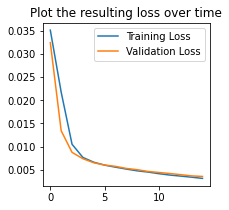

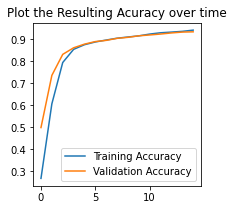

In [970]:
training_size=60000
test_size=10000
no_of_layers = 3
input_dim = 784
neurons_per_layer = [256,128,64,10]
dropout=0.2
learning_rate=0.001
training_epoch=15
batch_size=64
training = True
# this statement tell our code if there gpu available on our machine or not.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

transforms = transforms.Compose([transforms.Resize((28,28)), transforms.ToTensor(), transforms.Grayscale(), transforms.Normalize([0],[0.707])])

train_loader,val_loader,test_loader = dataset_load(transforms,batch_size)

model = init_network(no_of_layers, input_dim, neurons_per_layer,dropout,device)

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
loss_func = nn.NLLLoss()

if training==True:

  model, train_loss, train_accuracy, val_loss, val_accuracy  = train(model, train_loader, val_loader,learning_rate, training_epoch ,loss_func, optimizer, device)
  save_network("Model.pt", model) 
  train_vitualization(train_loss, train_accuracy, val_loss, val_accuracy)
else:
  load_network("Model.pt",model)
  actuals, predictions, test_accuracy,test_loss = test(model, device, test_loader)
  test_vitualization(actuals,predictions,test_accuracy,test_loss) 
  
  print("------------------------------------------------------------------------------")
  print("--------------------------Image Classification--------------------------------")
  image_predict(model, test_loader)